In [31]:
import os, time, cv2, sys, math
import tensorflow as tf
import argparse
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('../') # para poder importar utils, helpers y builders

from utils import utils, helpers
from builders import model_builder
from models.FC_DenseNet_Tiramisu import build_fc_densenet

# Definimos variables a utilizar

In [19]:
class Args():
    def __init__(self, ckpt_path=None, crop_height=None, crop_width=None, model=None, csv="class_dict.csv"):
        self.ckpt_path = ckpt_path
        self.model = model
        self.crop_height = crop_height
        self.crop_width = crop_width
        self.csv = csv
        self.img = None
    
    def load_img(self, dir_img):
        self.img = utils.load_image(dir_img)
        return self.img

args = Args(
    ckpt_path = '../checkpoints/latest_model_FC-DenseNet67_opends_format.ckpt', 
    crop_height = 640, crop_width = 400,
    model = 'FC-DenseNet67', csv = 'class_dict.csv'
)

# Cargamos la imagen

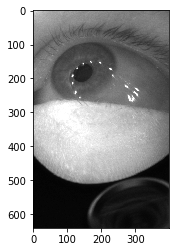

In [25]:
args.load_img('../640x400_small/test/000000010961.png') # se carga la imagen
plt.imshow(args.img)

# Informacion descriptiva

In [21]:
class_names_list, label_values = helpers.get_label_info(args.csv)
num_classes = len(label_values)

print("Model -->", args.model)
print("Crop Height -->", args.crop_height)
print("Crop Width -->", args.crop_width)
print("Num Classes -->", num_classes)

Model --> FC-DenseNet67
Crop Height --> 640
Crop Width --> 400
Num Classes --> 4


# Cargamos el modelo y contamos la cantidad total de parametros

In [26]:
# Initializing network
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess=tf.Session(config=config)
net_input = tf.placeholder(tf.float32,shape=[None,None,None,3])
net_output = tf.placeholder(tf.float32,shape=[None,None,None,num_classes]) 

network = build_fc_densenet(net_input, preset_model=args.model, num_classes=num_classes)

sess.run(tf.global_variables_initializer())
saver=tf.train.Saver(max_to_keep=1000)
saver.restore(sess, args.ckpt_path)
utils.count_params()

W1008 21:00:09.228329 140663660656448 deprecation_wrapper.py:119] From ../models/FC_DenseNet_Tiramisu.py:106: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W1008 21:00:35.080644 140663660656448 deprecation.py:323] From /home/choppy/anaconda3/envs/choppy/lib/python3.7/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
W1008 21:00:35.562175 140663660656448 deprecation_wrapper.py:119] From ../utils/utils.py:66: The name tf.trainable_variables is deprecated. Please use tf.compat.v1.trainable_variables instead.



This model has 202084 trainable parameters


# Se debe expandir la dimension del array de la imagen 3d a 4d

In [27]:
img = args.img
input_image = np.expand_dims(np.float32(img), axis=0)/255.0
input_image.shape

(1, 640, 400, 3)

# Obtenemos las mascaras predichas por el modelo

In [28]:
output_image = sess.run(network, feed_dict={net_input:input_image})
output_image.shape

(1, 640, 400, 4)

# Preprocesamos el mapa semantico del modelo

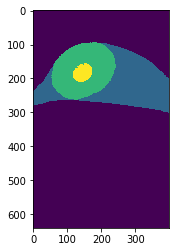

In [29]:
output_image = np.array(output_image[0,:,:,:])
output_image = helpers.reverse_one_hot(output_image)
plt.imshow(output_image)

# Transformamos el mapa semantico a imagen

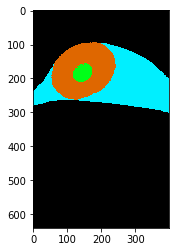

In [30]:
out_vis_image = helpers.colour_code_segmentation(output_image, label_values)
plt.imshow(out_vis_image)